In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import time
import numpy as np
import matplotlib.pyplot as plt
#import minopy.minopy_utilities as mnp
from miaplpy.lib.utils import est_corr_py
import miaplpy.simulation as mnp
from skimage.measure import label
import pandas as pd
from scipy import linalg as LA
from miaplpy.lib.utils import sequential_phase_linking_py, phase_linking_process_py, datum_connect_py


In [3]:
lamda = 56.0 #wavelength (mm)
n_img = 300
n_shp = 300
velocity = 4 #mm/y
velocity_fading = 50 #mm/y
tmp_bl = 6 #days

vel_phase = velocity/365*4*np.pi/lamda    #0.0024 # rad/day
decorr_days = 50

vel_fading = velocity_fading/365*4*np.pi/lamda  # 0.031 # rad/day
decorr_days_fading = 11

gamma0 = 0.6
gammaf_decor = 0
gammaf_cor = 0.2
gamma_fading = 0.18


In [4]:
temp_baseline = np.ogrid[0:(tmp_bl * n_img):tmp_bl]

coh_sim_S = mnp.simulate_coherence_matrix_exponential(temp_baseline, gamma0, gammaf_decor, gamma_fading, vel_phase, decorr_days, 
                                                        vel_fading, decorr_days_fading, seasonal=False)
coh_sim_L = mnp.simulate_coherence_matrix_exponential(temp_baseline, gamma0, gammaf_cor, gamma_fading, vel_phase, decorr_days, 
                                                        vel_fading, decorr_days_fading, seasonal=False)

CCGsam_Sterm = mnp.simulate_neighborhood_stack(coh_sim_S, neighborSamples=n_shp)
CCGsam_Lterm = mnp.simulate_neighborhood_stack(coh_sim_L, neighborSamples=n_shp)

coh_est_S = np.array(est_corr_py(CCGsam_Sterm))
coh_est_L = np.array(est_corr_py(CCGsam_Lterm))




In [5]:
tims = np.arange(10, 300)
times_taken = np.zeros((14, len(tims)))
tims.shape, times_taken.shape, time.time()

((290,), (14, 290), 1652577028.909924)

In [6]:
num_rep = 100
tims = np.arange(10, 300)
times_taken = np.zeros((14, len(tims)))

for tt in range(num_rep):
    CCGsam_Sterm = mnp.simulate_neighborhood_stack(coh_sim_S, neighborSamples=n_shp)
    CCGsam_Lterm = mnp.simulate_neighborhood_stack(coh_sim_L, neighborSamples=n_shp)

    for i in range(len(tims)):
        num_image = tims[i]
        ccg_short = CCGsam_Sterm[0:num_image, :]
        ccg_long = CCGsam_Lterm[0:num_image, :]
    
        ## sbw
        time0 = time.time()
        ph_stbas, noval, temp_quality = phase_linking_process_py(ccg_short, 0, b'SBW', False, 4)
        ph_stbas_short = np.angle(np.array(ph_stbas)).reshape(-1, 1) 
        times_taken[0, i] = times_taken[0, i] + time.time() - time0
    
        ## sbw
        time0 = time.time()
        ph_stbas, noval, temp_quality = phase_linking_process_py(ccg_long, 0, b'SBW', False, 4)
        ph_stbas_long = np.angle(np.array(ph_stbas)).reshape(-1, 1) 
        times_taken[1, i] = times_taken[1, i] + time.time() - time0
    
        ### EVD
        time0 = time.time()
        ph_EVD, noval, temp_quality = phase_linking_process_py(ccg_short, 0, b'EVD', False, 0)
        ph_EVD_short = np.angle(np.array(ph_EVD)).reshape(-1, 1)
        times_taken[2, i] = times_taken[2, i] + time.time() - time0
    
        time0 = time.time()
        ph_EVD, noval, temp_quality = phase_linking_process_py(ccg_long, 0, b'EVD', False, 0)
        ph_EVD_long = np.angle(np.array(ph_EVD)).reshape(-1, 1)
        times_taken[3, i] = times_taken[3, i] + time.time() - time0
    
        #### EMI
        time0 = time.time()
        ph_EMI, noval, temp_quality = phase_linking_process_py(ccg_short, 0, b'EMI', False, 0)
        ph_EMI_short = np.angle(np.array(ph_EMI)).reshape(-1, 1) 
        times_taken[4, i] = times_taken[4, i] + time.time() - time0
        
        time0 = time.time()
        ph_EMI, noval, temp_quality = phase_linking_process_py(ccg_long, 0, b'EMI', False, 0)
        ph_EMI_long = np.angle(np.array(ph_EMI)).reshape(-1, 1) 
        times_taken[5, i] = times_taken[5, i] + time.time() - time0

        #### PTA
        time0 = time.time()
        ph_PTA, noval, temp_quality = phase_linking_process_py(ccg_short, 0, b'PTA', False, 0)
        ph_PTA_short = np.angle(np.array(ph_PTA)).reshape(-1, 1) 
        times_taken[6, i] = times_taken[6, i] + time.time() - time0
    
        time0 = time.time()
        ph_PTA, noval, temp_quality = phase_linking_process_py(ccg_long, 0, b'PTA', False, 0)
        ph_PTA_long = np.angle(np.array(ph_PTA)).reshape(-1, 1) 
        times_taken[7, i] = times_taken[7, i] + time.time() - time0

        #### Sequential EVD
        
        num_seq = np.int(num_image // 10)
    
        time0 = time.time()
        ph_vec, sqeezed, temp_quality = sequential_phase_linking_py(ccg_short, b'EVD', 10, num_seq)
        ph_vec = datum_connect_py(sqeezed, ph_vec, 10)
        ph_vec_EVD_short = np.angle(np.array(ph_vec)).reshape(-1, 1) 
        times_taken[8, i] = times_taken[8, i] + time.time() - time0
    
        time0 = time.time()
        ph_vec, sqeezed, temp_quality = sequential_phase_linking_py(ccg_long, b'EVD', 10, num_seq)
        ph_vec = datum_connect_py(sqeezed, ph_vec, 10)
        ph_vec_EVD_long = np.angle(np.array(ph_vec)).reshape(-1, 1) 
        times_taken[9, i] = times_taken[9, i] + time.time() - time0

        #### Sequential EMI
        time0 = time.time()
        ph_vec, sqeezed, temp_quality = sequential_phase_linking_py(ccg_short, b'EMI', 10, num_seq)
        ph_vec = datum_connect_py(sqeezed, ph_vec, 10)
        ph_vec_EMI_short = np.angle(np.array(ph_vec)).reshape(-1, 1) 
        times_taken[10, i] = times_taken[10, i] + time.time() - time0
    
    
        time0 = time.time()
        ph_vec, sqeezed, temp_quality = sequential_phase_linking_py(ccg_long, b'EMI', 10, num_seq)
        ph_vec = datum_connect_py(sqeezed, ph_vec, 10)
        ph_vec_EMI_long = np.angle(np.array(ph_vec)).reshape(-1, 1) 
        times_taken[11, i] = times_taken[11, i] + time.time() - time0


        #### Sequential PTA
        time0 = time.time()
        ph_vec, sqeezed, temp_quality = sequential_phase_linking_py(ccg_short, b'PTA', 10, num_seq)
        ph_vec = datum_connect_py(sqeezed, ph_vec, 10)
        ph_vec_PTA_short = np.angle(np.array(ph_vec)).reshape(-1, 1)
        times_taken[12, i] = times_taken[12, i] + time.time() - time0
    
        time0 = time.time()
        ph_vec, sqeezed, temp_quality = sequential_phase_linking_py(ccg_long, b'PTA', 10, num_seq)
        ph_vec = datum_connect_py(sqeezed, ph_vec, 10)
        ph_vec_PTA_long = np.angle(np.array(ph_vec)).reshape(-1, 1) 
        times_taken[13, i] = times_taken[13, i] + time.time() - time0
    
times_taken = times_taken/num_rep

In [18]:
#np.save('./simulation/time_scale.npy', times_taken/1000)

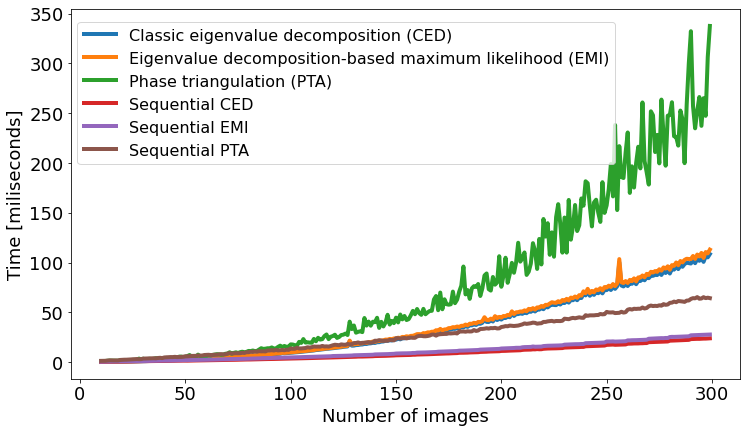

In [27]:
plt.rcParams["font.size"] = "18"

times_taken = np.load('./simulation/time_scale.npy')*1000

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,6.8))

'''
ax = axs
#ax.plot(tims, times_taken[0, :])
ax.plot(tims, times_taken[2, :])
ax.plot(tims, times_taken[4, :])
ax.plot(tims, times_taken[6, :])
ax.plot(tims, times_taken[8, :])
ax.plot(tims, times_taken[10, :])
ax.plot(tims, times_taken[12, :])

'''
ax = axs
#ax.plot(tims, times_taken[1, :])
ax.plot(tims, times_taken[3, :], linewidth=4)
ax.plot(tims, times_taken[5, :], linewidth=4)
ax.plot(tims, times_taken[7, :], linewidth=4)
ax.plot(tims, times_taken[9, :], linewidth=4)
ax.plot(tims, times_taken[11, :], linewidth=4)
ax.plot(tims, times_taken[13, :], linewidth=4)


ax.set_ylabel('Time [miliseconds]')
ax.set_xlabel('Number of images')
ax.legend(['Classic eigenvalue decomposition (CED)', 
           'Eigenvalue decomposition-based maximum likelihood (EMI)', 
           'Phase triangulation (PTA)', 
           'Sequential CED', 'Sequential EMI', 'Sequential PTA'], loc=(0.01, 0.58), fontsize=16)

plt.savefig('./out_figures/timing_scale.png', bbox_inches='tight', transparent=True, dpi=300)

[1 2 3 4 5 6]


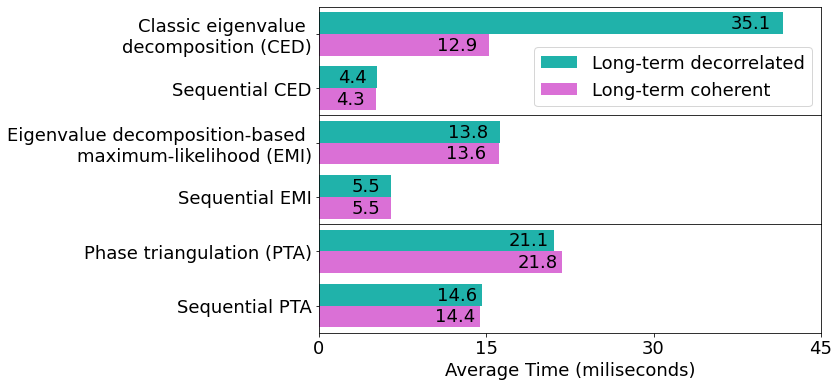

In [28]:
plt.rcParams["font.size"] = "18"

colors = ['lightseagreen','orchid','maroon','lime','green','darkorchid','red']
timesmat = np.load('./simulation/rmsemat_linear_seasonal_time.npy')
timesmat = timesmat*1000

labels = ['Classic eigenvalue \ndecomposition (CED)', 
          'Eigenvalue decomposition-based \nmaximum-likelihood (EMI)',
          'Phase triangulation (PTA)', 
          'Sequential CED',
          'Sequential EMI',
          'Sequential PTA']


height = 0.4 
#fontsize=14
#,fontsize=fontsize
ind1 = np.arange(1, 7)
print(ind1)
ind = np.sort(np.array([ind1-height/2,ind1+height/2]).reshape(-1))

fig, ax = plt.subplots(3, 1, figsize=(9,6))

ax[0].barh(ind[0],timesmat[0],height=height,color=colors[0])
ax[0].barh(ind[1],timesmat[1],height=height,color=colors[1])
ax[0].barh(ind[2],timesmat[6],height=height,color=colors[0])
ax[0].barh(ind[3],timesmat[7],height=height,color=colors[1])
ax[0].set_ylim(0.5,2.5)
ax[0].set_xlim(0,38)

ax[0].set(xticklabels=[])
ax[0].set_yticks([1,2])
ax[0].set_yticklabels([labels[0],labels[3]])
ax[0].legend(('Long-term decorrelated','Long-term coherent'), loc='lower right')
ax[0].text(timesmat[0]-4, 0.9, str(round(timesmat[0],1)))
ax[0].text(timesmat[1]-4, 1.3, str(round(timesmat[1],1)))
ax[0].text(timesmat[6]-3, 1.9, str(round(timesmat[6],1)))
ax[0].text(timesmat[7]-3, 2.3, str(round(timesmat[7],1)))
ax[0].invert_yaxis()


ax[1].barh(ind[0],timesmat[2],height=height,color=colors[0])
ax[1].barh(ind[1],timesmat[3],height=height,color=colors[1])
ax[1].barh(ind[2],timesmat[8],height=height,color=colors[0])
ax[1].barh(ind[3],timesmat[9],height=height,color=colors[1])
ax[1].set_ylim(0.5,2.5)
ax[1].set_yticks([1,2])
ax[1].set(xticklabels=[])
ax[1].set_xlim(0,38)
ax[1].set_yticklabels([labels[1],labels[4]])
ax[1].text(timesmat[2]-4, 0.9, str(round(timesmat[2],1)))
ax[1].text(timesmat[3]-4, 1.3, str(round(timesmat[3],1)))
ax[1].text(timesmat[8]-3, 1.9, str(round(timesmat[8],1)))
ax[1].text(timesmat[9]-3, 2.3, str(round(timesmat[9],1)))
ax[1].invert_yaxis()


ax[2].barh(ind[0],timesmat[4],height=height,color=colors[0])
ax[2].barh(ind[1],timesmat[5],height=height,color=colors[1])
ax[2].barh(ind[2],timesmat[10],height=height,color=colors[0])
ax[2].barh(ind[3],timesmat[11],height=height,color=colors[1])
ax[2].set_ylim(0.5,2.5)
ax[2].set_yticks([1,2])
ax[2].set_xticks([0, 15, 30, 45])
ax[2].set_xlim(0,45)
ax[2].set_yticklabels([labels[2],labels[5]])
ax[2].text(timesmat[4]-4, 0.9, str(round(timesmat[4],1)))
ax[2].text(timesmat[5]-4, 1.3, str(round(timesmat[5],1)))
ax[2].text(timesmat[10]-4, 1.9, str(round(timesmat[10],1)))
ax[2].text(timesmat[11]-4, 2.3, str(round(timesmat[11],1)))
ax[2].invert_yaxis()
ax[2].set_xlabel('Average Time (miliseconds)')

fig.subplots_adjust(hspace=0,wspace=0.1)
#plt.savefig('simulation/timeplot.eps', bbox_inches='tight', transparent=True)
plt.savefig('./out_figures/timeplot_2.png', bbox_inches='tight', transparent=True, dpi=300)
plt.show()
